In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# pd.set_option("display.precision", 4)

from modules.parseMatrix import parseMatrixRows, parseMatrixColumns, parseMatrixIndexes

from modules.model import BarProps, Point, Bar
from modules.matrices import BarStiffnessMatrix, TransformationMatrix, LoadMatrix
from modules.internalForces import *

## Vstupy

In [2]:
crossSection = {"width": 200, "height": 300}
material = "C30/37"
barProps = BarProps(material, crossSection)
print("E = ", barProps.E, "kPa")
print("I = ", barProps.I, "m-4")
print("A = ", barProps.A, "m2")

E =  33000000.0 kPa
I =  0.00044999999999999993 m-4
A =  0.06 m2


In [3]:
# lengths
A = 3 #m
B = 3 #m
C = 3 #m

# loads
F = 40 #kN
Q = 5 #kN/m

Definovanie bodov

In [4]:
p1 = Point(0,0)
p2 = Point(0,3)
p3 = Point(3,3)
p4 = Point(3,0)

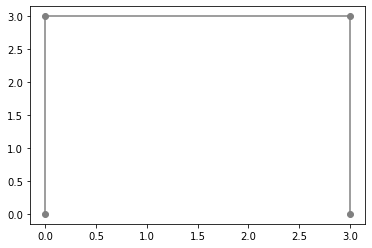

In [5]:
y = np.array([p1.y,p2.y,p3.y,p4.y])
x = np.array([p1.x,p2.x,p3.x,p4.x])
plt.plot(x,y, 'o-', color='gray')

Podpery

In [6]:
p1.stiff
p4.hinge
print(p1)
print(p2)
print(p3)
print(p4)

Point(x=0, y=0, dof=[0, 0, 0])
Point(x=0, y=3, dof=[1, 1, 1])
Point(x=3, y=3, dof=[1, 1, 1])
Point(x=3, y=0, dof=[0, 0, 1])


Definovanie prútov

In [7]:
bar12 = Bar(p1, p2)
bar23 = Bar(p2, p3)
bar34 = Bar(p3, p4)
print('bar12 =', bar12.len, 'm')
print('bar23 =', bar23.len, 'm')
print('bar34 =', bar34.len, 'm')

bar12 = 3.0 m
bar23 = 3.0 m
bar34 = 3.0 m


## Vzorové riešenie na prúte 1-2

### Matica tuhosti v LSS

In [8]:
k12 = BarStiffnessMatrix.lss(barProps, bar12)
k12

,0,1,2
0,660000.0,0.0,0.0
1,0.0,6600.0,9900.0
2,0.0,9900.0,19800.0


### Matica rotácie

Uhol rotácie

In [9]:
alfa_1 = bar12.angle
alfa_1

-90.0

Matica

In [10]:
A0_1 = TransformationMatrix.rotation(alfa_1)
A0_1

,0,1,2
0,6.123234e-17,-1.000000e+00,0
1,1.000000e+00,6.123234e-17,0
2,0.000000e+00,0.000000e+00,1


### Prenosová matica

Posun

In [11]:
lx = bar12.l_xy[0]
ly = bar12.l_xy[1]
print('lx = ', lx)
print('ly = ', ly)

lx =  0
ly =  -3


Matica

In [12]:
B0_1 = TransformationMatrix.transmission(lx, ly)
B0_1

,0,1,2
0,-1,0,0
1,0,-1,0
2,3,0,-1


### Matica tuhosti v GSS

In [13]:
k1 = BarStiffnessMatrix.gss(A0_1, k12, B0_1)
k1 = parseMatrixIndexes(k1, [0,1,2,3,4,5])
k1

,0,1,2,3,4,5
0,6.600000e+03,-4.000921e-11,9.900000e+03,-6.600000e+03,4.000921e-11,9.900000e+03
1,-4.000921e-11,6.600000e+05,6.062002e-13,4.000921e-11,-6.600000e+05,-1.206338e-10
2,9.900000e+03,6.062002e-13,1.980000e+04,-9.900000e+03,-6.062002e-13,9.900000e+03
3,-6.600000e+03,4.000921e-11,-9.900000e+03,6.600000e+03,-4.000921e-11,-9.900000e+03
4,4.000921e-11,-6.600000e+05,-6.062002e-13,-4.000921e-11,6.600000e+05,1.206338e-10
5,9.900000e+03,-1.206338e-10,9.900000e+03,-9.900000e+03,1.206338e-10,1.980000e+04


### Primárne vnútorné sily

Vnútorné sily - *Bod 1*

In [14]:
load = Load(Q = Q)
M1 = BendingMoment(load, bar12)
V1 = ShearForce(load, bar12)
print("N_12 = ", 0, "kN")
print("V_12 = ", V1.Va, "kN")
print("M_12 = ", M1.Ma, "kNm")

N_12 =  0 kN
V_12 =  -7.5 kN
M_12 =  -3.75 kNm


Vnútorné sily - *Bod 2*

In [15]:
M1 = BendingMoment(load, bar12)
V1 = ShearForce(load, bar12)
print("N_21 = ", 0, "kN")
print("V_21 = ", V1.Vb, "kN")
print("M_21 = ", M1.Mb, "kNm")

N_21 =  0 kN
V_21 =  -7.5 kN
M_21 =  3.75 kNm


Silový vektor v LSS - *Bod 1*

In [16]:
F12_l = LoadMatrix.lss(0, V1.Va, M1.Ma)
F12_l

,0
0,0.00
1,-7.50
2,-3.75


Silový vektor v LSS - *Bod 2*

In [17]:
F21_l = LoadMatrix.lss(0, V1.Vb, M1.Mb)
F21_l

,0
0,0.00
1,-7.50
2,3.75


Silový vektor v GSS pre celý prút

In [18]:
F12_g = LoadMatrix.gss(F12_l, A0_1.T)
F21_g = LoadMatrix.gss(F21_l, A0_1.T)

F1 = LoadMatrix.super(F12_g, F21_g)
F1 = parseMatrixRows(F1,[0,1,2,3,4,5])
F1

,0
0,-7.500000e+00
1,-4.592425e-16
2,-3.750000e+00
3,-7.500000e+00
4,-4.592425e-16
5,3.750000e+00


## Riešenie na prúte 2-3

In [19]:
lx = bar23.l_xy[0]
ly = bar23.l_xy[1]
print('lx = ', lx)
print('ly = ', ly)

lx =  3
ly =  0


In [20]:
k23 = BarStiffnessMatrix.lss(barProps, bar23)
A0_2 = TransformationMatrix.rotation(bar23.angle)
B0_2 = TransformationMatrix.transmission(lx, ly)

In [21]:
k2 = BarStiffnessMatrix.gss(A0_2, k23, B0_2)
k2 = parseMatrixIndexes(k2,[3,4,5,6,7,8])
k2

,3,4,5,6,7,8
3,660000.0,0.0,0.0,-660000.0,0.0,0.0
4,0.0,6600.0,9900.0,0.0,-6600.0,9900.0
5,0.0,9900.0,19800.0,0.0,-9900.0,9900.0
6,-660000.0,0.0,0.0,660000.0,0.0,0.0
7,0.0,-6600.0,-9900.0,0.0,6600.0,-9900.0
8,0.0,9900.0,9900.0,0.0,-9900.0,19800.0


In [22]:
load = Load(F = F)
M2 = BendingMoment(load, bar23)
V2 = ShearForce(load, bar23)

In [23]:
F23_l = LoadMatrix.lss(0, V2.Va, M2.Ma)
F32_l = LoadMatrix.lss(0, V2.Vb, M2.Mb)
F23_g = LoadMatrix.gss(F23_l, A0_2.T)
F32_g = LoadMatrix.gss(F32_l, A0_2.T)

F2 = LoadMatrix.super(F23_g, F32_g)
F2 = parseMatrixRows(F2,[3,4,5,6,7,8])
F2

,0
3,0.0
4,-20.0
5,-15.0
6,0.0
7,-20.0
8,15.0


## Riešenie na prúte 3-4

In [24]:
lx = bar34.l_xy[0]
ly = bar34.l_xy[1]
print('lx = ', lx)
print('ly = ', ly)

lx =  0
ly =  3


In [25]:
k34 = BarStiffnessMatrix.lss(barProps, bar34)
A0_3 = TransformationMatrix.rotation(bar34.angle)
B0_3 = TransformationMatrix.transmission(lx, ly)

In [26]:
k3 = BarStiffnessMatrix.gss(A0_3, k34, B0_3)
k3 = parseMatrixIndexes(k3,[6,7,8,9,10,11])
k3

,6,7,8,9,10,11
6,6.600000e+03,4.000921e-11,-9.900000e+03,-6.600000e+03,-4.000921e-11,-9.900000e+03
7,4.000921e-11,6.600000e+05,6.062002e-13,-4.000921e-11,-6.600000e+05,-1.206338e-10
8,-9.900000e+03,6.062002e-13,1.980000e+04,9.900000e+03,-6.062002e-13,9.900000e+03
9,-6.600000e+03,-4.000921e-11,9.900000e+03,6.600000e+03,4.000921e-11,9.900000e+03
10,-4.000921e-11,-6.600000e+05,-6.062002e-13,4.000921e-11,6.600000e+05,1.206338e-10
11,-9.900000e+03,-1.206338e-10,9.900000e+03,9.900000e+03,1.206338e-10,1.980000e+04


In [27]:
load = Load()
M3 = BendingMoment(load, bar34)
V3 = ShearForce(load, bar34)

In [28]:
F34_l = LoadMatrix.lss(0, V3.Va, M3.Ma)
F43_l = LoadMatrix.lss(0, V3.Vb, M3.Mb)
F34_g = LoadMatrix.gss(F34_l, A0_3.T)
F43_g = LoadMatrix.gss(F43_l, A0_3.T)

F3 = LoadMatrix.super(F34_g, F43_g)
F3 = parseMatrixRows(F3,[0,1,2,3,4,5])
F3 = parseMatrixRows(F3,[6,7,8,9,10,11])
F3

,0
6,0.0
7,0.0
8,0.0
9,0.0
10,0.0
11,0.0


## Matica tuhosti celého rámu

In [29]:
zeros = pd.DataFrame(np.zeros((12, 12)))
zeros

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Matica tuhosti bez zohľadnenia okrajových podmienok

In [30]:
def modelMatrix(zeros, k1, k2, k3):
    layer1 = zeros.add(k1,fill_value=0)
    layer2 = layer1.add(k2,fill_value=0)
    layer3 = layer2.add(k3,fill_value=0)
    return layer3

In [31]:
modelMatrix = modelMatrix(zeros,k1,k2,k3)

In [32]:
def highlightNotZero(x):
    if x < 0:
        #red
        color = "#ff9999"
    elif x > 0:
        #green
        color = "#ccffcc"
    else:
        color = "#f2f2f2"
    return f"background: {color}"

def parseZeroValues(x):
    if x != 0:
        return '{:.3e}'
    else:
        return '{:.0f}'

In [33]:
modelMatrix.style\
.format('{:.3e}')\
.applymap(highlightNotZero)\
.set_table_styles([{"selector" : "", "props" : [("font-family", "arial")]}]) 


,0,1,2,3,4,5,6,7,8,9,10,11
0,6.600e+03,-4.001e-11,9.900e+03,-6.600e+03,4.001e-11,9.900e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
1,-4.001e-11,6.600e+05,6.062e-13,4.001e-11,-6.600e+05,-1.206e-10,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
2,9.900e+03,6.062e-13,1.980e+04,-9.900e+03,-6.062e-13,9.900e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
3,-6.600e+03,4.001e-11,-9.900e+03,6.666e+05,-4.001e-11,-9.900e+03,-6.600e+05,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
4,4.001e-11,-6.600e+05,-6.062e-13,-4.001e-11,6.666e+05,9.900e+03,0.000e+00,-6.600e+03,9.900e+03,0.000e+00,0.000e+00,0.000e+00
5,9.900e+03,-1.206e-10,9.900e+03,-9.900e+03,9.900e+03,3.960e+04,0.000e+00,-9.900e+03,9.900e+03,0.000e+00,0.000e+00,0.000e+00
6,0.000e+00,0.000e+00,0.000e+00,-6.600e+05,0.000e+00,0.000e+00,6.666e+05,4.001e-11,-9.900e+03,-6.600e+03,-4.001e-11,-9.900e+03
7,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-6.600e+03,-9.900e+03,4.001e-11,6.666e+05,-9.900e+03,-4.001e-11,-6.600e+05,-1.206e-10
8,0.000e+00,0.000e+00,0.000e+00,0.000e+00,9.900e+03,9.900e+03,-9.900e+03,-9.900e+03,3.960e+04,9.900e+03,-6.062e-13,9.900e+03
9,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-6.600e+03,-4.001e-11,9.900e+03,6.600e+03,4.001e-11,9.900e+03


## Matica tuhosti zohľadňujúca okrajové podmienky

In [34]:
def loadVector(F1,F2,F3):
    x = F1.add(F2,fill_value=0)
    loadVector = x.add(F3,fill_value=0)
    return loadVector

Silový vektor celého rámu

In [35]:
loadVector = loadVector(F1,F2,F3)
loadVector

,0
0,-7.500000e+00
1,-4.592425e-16
2,-3.750000e+00
3,-7.500000e+00
4,-2.000000e+01
5,-1.125000e+01
6,0.000000e+00
7,-2.000000e+01
8,1.500000e+01
9,0.000000e+00
